In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

os.chdir("../../") # step into the main project dir

In [2]:
from training.data import get_transform_list, get_dataset, CombinedDataset, Subset
from training.models import get_distilgpt2_srn18_vae

import random
import time

In [3]:
import torch

def seed_torch(seed: int):
    """
    Seed all torch random number generators and set the deterministic flag.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [4]:
# prepare data ----------------------------------------------------------------------------------
SEED = 14
DATA_DIR = "data/mscoco"

transform_list = get_transform_list()
# get datasets
train_ds = get_dataset(transform_list, dataset_type="train2014", data_dir=DATA_DIR, seed=SEED)
val_ds = get_dataset(transform_list, dataset_type="val2014", data_dir=DATA_DIR, seed=SEED)
test_ds = get_dataset(transform_list, dataset_type="test2014", data_dir=DATA_DIR, seed=SEED)

random_gen = random.Random(SEED)
n_subset = 4
train_idxs = random_gen.sample(range(len(train_ds)), n_subset)
test_idxs = random_gen.sample(range(len(test_ds)), n_subset)

# sample subsets
train_subset = Subset(train_ds, train_idxs)
test_subset = Subset(test_ds, test_idxs)

mia_ds = CombinedDataset(train_subset, test_subset, 1, 0)

seed_torch(SEED)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!
loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [5]:
# prepare model ---------------------------------------------------------------------------------
device = 'cuda'
# device='cpu'

param_dict = {
    'captioner_weights': "logs/tests/srn18_vae_dgpt2_z3/best.pth",
    'mixed_precision': 1,
    'freeze_encoder': 0, # only affects things if ur finetuning the model
}
model = get_distilgpt2_srn18_vae(param_dict)
model.eval()
model = model.to(device)


loading captioner weights from: logs/tests/srn18_vae_dgpt2_z3/best.pth


For all generation methods, results are output as dictionaries with the keys:
`['idx', 'ids', 'tokens']`

*(tokens are output by default but can be disabled by passing decode=False to the generation function)*

# 1. Generate Single Captions

In [ ]:
# pass a single image to the function
for i, data in enumerate(mia_ds):
    print(f"\nimage {i} {'-'*40}")
    image = data["image"]
    # image, _ = data
    start_time = time.time()
    output = model.generate_caption(image)
    print(f"elapsed: {time.time() - start_time:.3f}s")
    print(f"output: {output}")



image 0 ----------------------------------------
started generation supervisor...
elapsed: 2.544s
output: {'idx': 0, 'ids': [50256, 32, 582, 10311, 1341, 271, 866, 257, 6729, 5017, 22638, 13, 50256], 'tokens': 'A man riding skis down a snow covered slope.'}

image 1 ----------------------------------------
started generation supervisor...
elapsed: 2.833s
output: {'idx': 0, 'ids': [50256, 32, 1448, 286, 661, 5055, 319, 1353, 286, 257, 6729, 5017, 22638, 13, 50256], 'tokens': 'A group of people standing on top of a snow covered slope.'}

image 2 ----------------------------------------
started generation supervisor...
elapsed: 2.679s
output: {'idx': 0, 'ids': [50256, 32, 1448, 286, 661, 5055, 319, 1353, 286, 257, 37408, 4077, 2214, 13, 50256], 'tokens': 'A group of people standing on top of a lush green field.'}

image 3 ----------------------------------------
started generation supervisor...
elapsed: 2.818s
output: {'idx': 0, 'ids': [50256, 32, 582, 10311, 257, 22647, 3526, 510, 262, 

# 2. Generate Batches of Captions

In [6]:
print('\n\nbatch image test')
batch_outputs = model.generate_batch_captions(mia_ds)
for outputs in batch_outputs:
    print(f"\nimage {outputs['idx']} {'-'*40}")
    print(outputs)




batch image test
started generation supervisor...


main:   0%|          | 0/20 [00:00<?, ?it/s]

[w:   0] [i: ?] |            | , status=starting up

[w:   1] [i: ?] |            | , status=starting up

[w:   2] [i: ?] |            | , status=starting up

[w:   3] [i: ?] |            | , status=starting up

[w:   4] [i: ?] |            | , status=starting up

[w:   5] [i: ?] |            | , status=starting up

[w:   6] [i: ?] |            | , status=starting up

[w:   7] [i: ?] |            | , status=starting up

[w:   8] [i: ?] |            | , status=starting up

[w:   9] [i: ?] |            | , status=starting up

[w:  10] [i: ?] |            | , status=starting up

[w:  11] [i: ?] |            | , status=starting up

[w:  12] [i: ?] |            | , status=starting up

[w:  13] [i: ?] |            | , status=starting up

[w:  14] [i: ?] |            | , status=starting up

[w:  15] [i: ?] |            | , status=starting up

[w:  16] [i: ?] |            | , status=starting up

[w:  17] [i: ?] |            | , status=starting up

[w:  18] [i: ?] |            | , status=starting up

[w:  19] [i: ?] |            | , status=starting up


image 0 ----------------------------------------
{'idx': 0, 'ids': [50256, 32, 582, 10311, 1341, 271, 866, 257, 6729, 5017, 22638, 13, 50256], 'tokens': 'A man riding skis down a snow covered slope.'}

image 1 ----------------------------------------
{'idx': 1, 'ids': [50256, 32, 1448, 286, 661, 5055, 319, 1353, 286, 257, 6729, 5017, 22638, 13, 50256], 'tokens': 'A group of people standing on top of a snow covered slope.'}

image 2 ----------------------------------------
{'idx': 2, 'ids': [50256, 32, 1448, 286, 661, 5055, 319, 1353, 286, 257, 37408, 4077, 2214, 13, 50256], 'tokens': 'A group of people standing on top of a lush green field.'}

image 3 ----------------------------------------
{'idx': 3, 'ids': [50256, 32, 582, 10311, 257, 22647, 3526, 510, 262, 1735, 286, 257, 10454, 13, 50256], 'tokens': 'A man riding a skateboard up the side of a ramp.'}

image 4 ----------------------------------------
{'idx': 4, 'ids': [50256, 32, 3084, 20633, 351, 257, 7480, 286, 2057, 290, 257, 4

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

image 0 --------------------------------------------------------------------------------



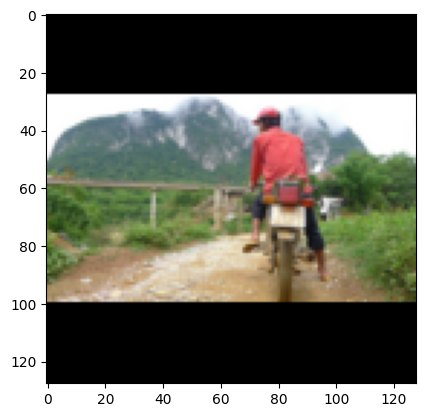


original caption:	A man riding on the back of a motorcycle.

predicted caption:	A group of giraffes are standing in a field.


image 1 --------------------------------------------------------------------------------



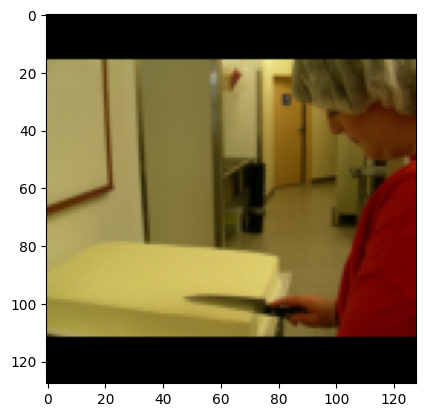


original caption:	A woman wearing a hair net cutting a large sheet cake.

predicted caption:	A cat sitting on top of a toilet seat.


image 2 --------------------------------------------------------------------------------



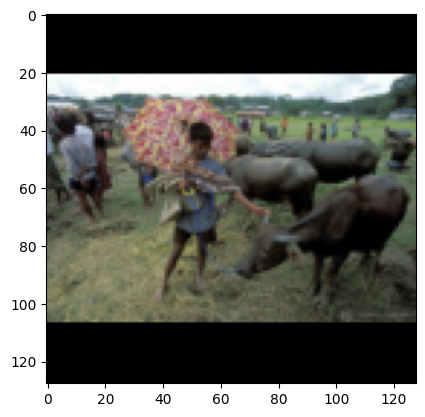


original caption:	A young man holding an umbrella next to a herd of cattle.

predicted caption:	A herd of elephants walking across a lush green field.


image 3 --------------------------------------------------------------------------------



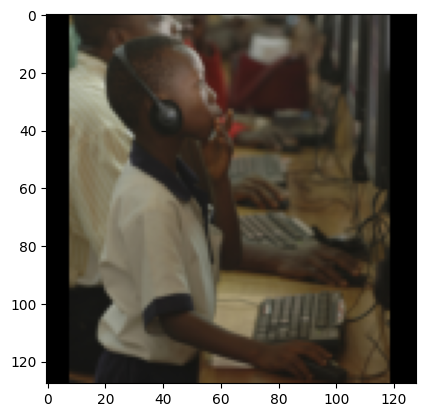

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].



original caption:	a little boy wearing headphones and looking at a computer monitor

predicted caption:	A dog is laying on a bed with a blanket.


image 4 --------------------------------------------------------------------------------



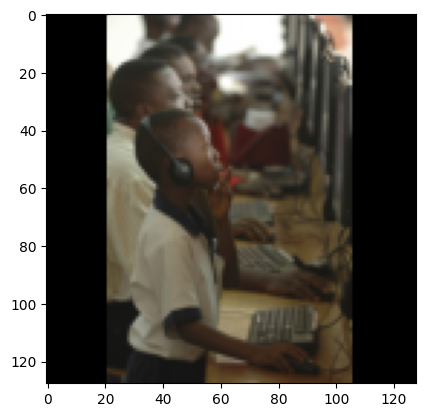


original caption:	A little boy with earphones on listening to something.

predicted caption:	A giraffe standing next to a wooden fence.


image 5 --------------------------------------------------------------------------------



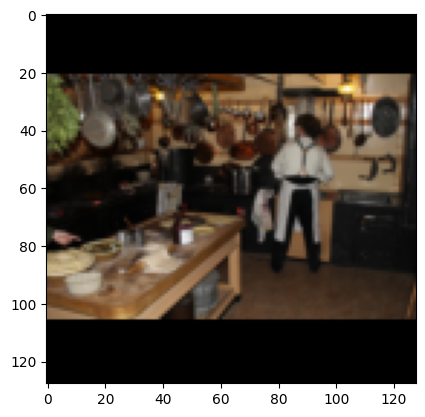


original caption:	Man in apron standing on front of oven with pans and bakeware

predicted caption:	A group of people sitting on a wooden bench.


image 6 --------------------------------------------------------------------------------



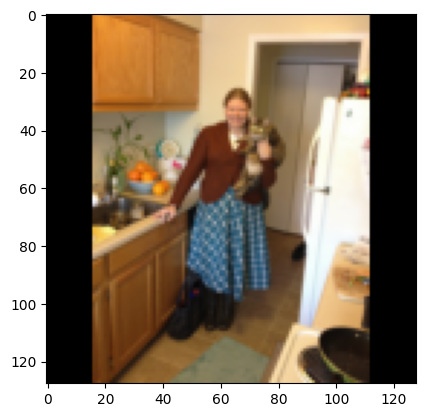


original caption:	A girl smiles as she holds a cat and wears a brightly colored skirt.

predicted caption:	A man in a suit and tie standing in a room.


image 7 --------------------------------------------------------------------------------



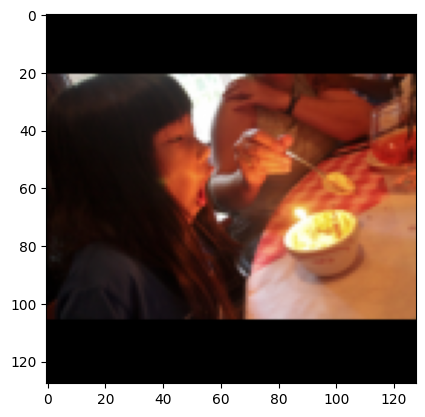


original caption:	A young girl is preparing to blow out her candle.

predicted caption:	A man in a red shirt eating a hot dog.


image 8 --------------------------------------------------------------------------------



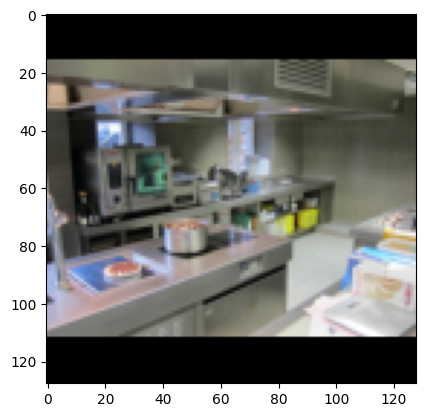


original caption:	A commercial stainless kitchen with a pot of food cooking.

predicted caption:	A cat laying on top of a wooden bench.


image 9 --------------------------------------------------------------------------------



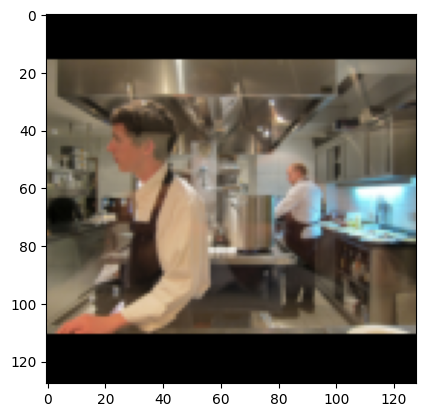


original caption:	two men in white shirts in a large steel kitchen

predicted caption:	A man and a woman sitting at a table with food.




In [6]:
model.eval()

for i, (image, caption) in enumerate(val_ds):
    if i >= 10:
        break
    print(f"image {i} {'-'*80}\n")
    plt.imshow(cv.cvtColor(np.moveaxis(image.numpy(), 0, 2), cv.COLOR_BGR2RGB))
    plt.show()
    pred_dict = model.generate_caption_LEGACY(image)
    print(f"\noriginal caption:\t{caption}")
    print(f"\npredicted caption:\t{pred_dict['tokens']}\n\n")

In [15]:
import torch

# Function to find the last non-zero index along dimension 1
def last_nonzero_index(attention_mask, dim=1):
    # Flip the tensor along the specified dimension
    flipped_mask = torch.flip(attention_mask, dims=[dim])
    nonzero_indices = (flipped_mask != 0).to(torch.int).argmax(dim=dim)

    # Find the first non-zero index in the flipped tensor
    # nonzero_indices = (flipped_mask != 0).to(torch.int).argmax(dim=dim)

    # Correct the index to the original orientation
    return attention_mask.size(dim) - nonzero_indices - 1


test_mask = torch.tensor(
        [
            [1, 0, 0, 0, 0, 0, 0, 0], 
            [1, 1, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 1, 0, 0, 0, 0]
        ]
)
print(test_mask.shape)
nz_idx = last_nonzero_index(test_mask, dim=1)
print(nz_idx)

torch.Size([3, 8])
tensor([0, 1, 3])


In [21]:
test_mask[:, nz_idx].shape

torch.Size([3, 3])